In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
std = StandardScaler()
dataNorm = std.fit_transform(data)

In [ ]:
#count the number of rows with number 7
count_7 = np.count_nonzero(labels == 7)

In [ ]:
#Reduce the number of 7's to 500 (randomly selected)
rows_7 = np.where(labels ==7)

#select 500 random rows
rows_7_select = np.random.choice(rows_7[0], size=500, replace=False)

In [ ]:
dataNorm_new = np.concat((np.delete(dataNorm, rows_7[0],axis=0),dataNorm[rows_7_select]),axis=0)
# labels_new = np.concat((np.delete(labels, rows_7[0],axis=0),labels[rows_select]),axis=0)
labels_new = np.hstack((np.delete(labels, rows_7[0],axis=0),labels[rows_7_select]))


In [ ]:
np.unique(labels_new, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([1962, 2243, 1989, 2021, 1924, 1761, 2039,  500, 1912, 2023]))

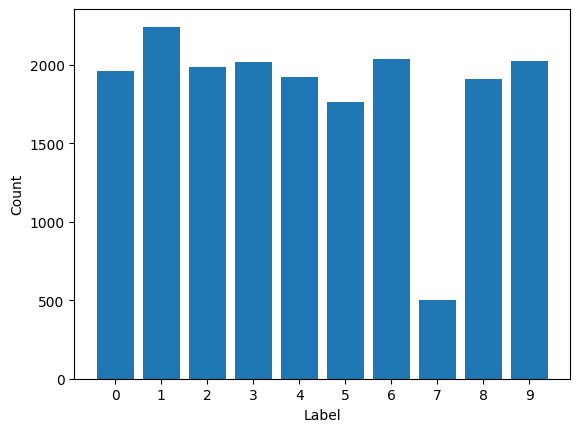

In [ ]:
#Plot bar graph with count of data for each label
labels_unique, counts = np.unique(labels_new, return_counts=True)
plt.bar(labels_unique, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(labels_unique)
plt.show();

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm_new ).float()
labelsT = torch.tensor( labels_new ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create a DL model

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model

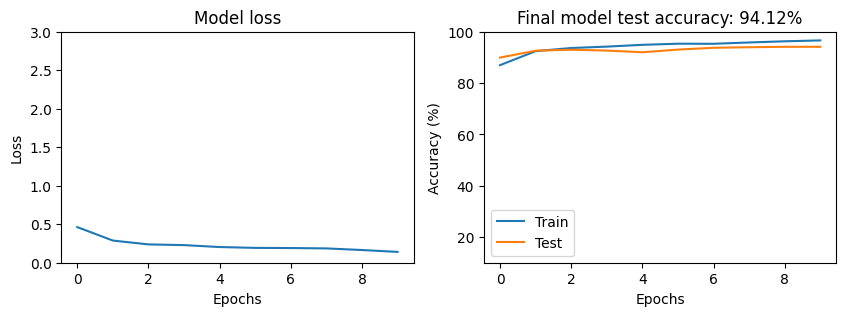

In [ ]:
# build and train the model
trainAcc,testAcc,losses,net = function2trainTheModel()


# visualization starts here
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show();

# Evaluate the model

In [ ]:
#Predictions from training data
yHat = net(train_loader.dataset.tensors[0])
train_pred = torch.argmax(yHat,axis=1)

#Predictions from test data
yHat = net(test_loader.dataset.tensors[0])
test_pred = torch.argmax(yHat, axis=1)
test_pred

tensor([8, 5, 0,  ..., 9, 9, 4])

In [ ]:
#Calculate precision scores
precision_score(train_labels, train_pred, average='macro')

0.9727155264431658

In [ ]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = accuracy_score(train_loader.dataset.tensors[1],train_pred) # accuracy is overall
train_metrics[1] = precision_score(train_loader.dataset.tensors[1],train_pred,average='weighted')
train_metrics[2] = recall_score(train_loader.dataset.tensors[1],train_pred,average='weighted')
train_metrics[3] = f1_score(train_loader.dataset.tensors[1],train_pred,average='weighted')


# test
test_metrics[0] = accuracy_score (test_loader.dataset.tensors[1],test_pred)
test_metrics[1] = precision_score(test_loader.dataset.tensors[1],test_pred,average='weighted')
test_metrics[2] = recall_score   (test_loader.dataset.tensors[1],test_pred,average='weighted')
test_metrics[3] = f1_score       (test_loader.dataset.tensors[1],test_pred,average='weighted')

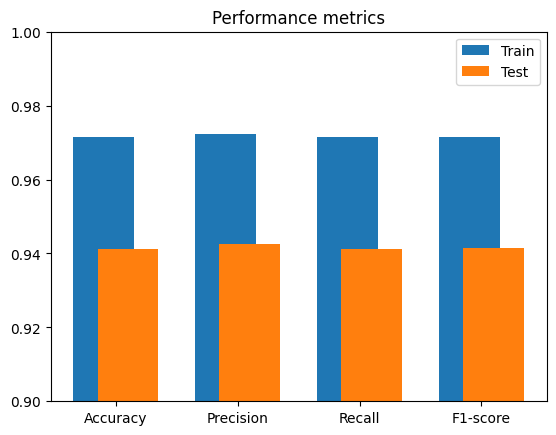

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
# plt.bar(np.arange(4),train_metrics,.5)
# plt.bar(np.arange(4),test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show();

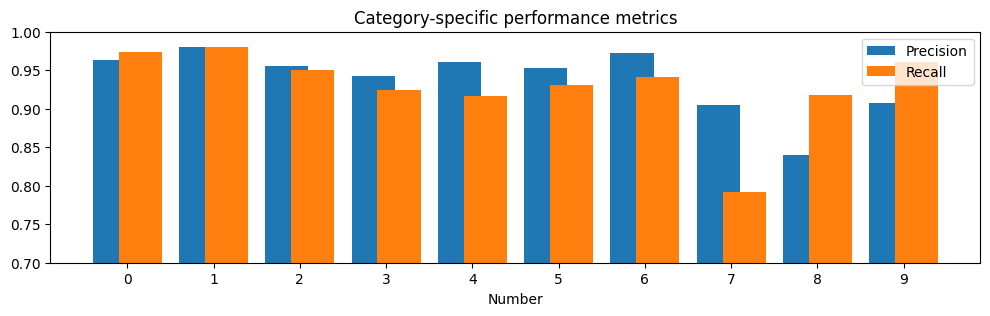

In [ ]:
# Bar graphs of class-specific precision and recall for test data

precision = precision_score(test_loader.dataset.tensors[1],test_pred,average=None)
recall    = recall_score   (test_loader.dataset.tensors[1],test_pred,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.7,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

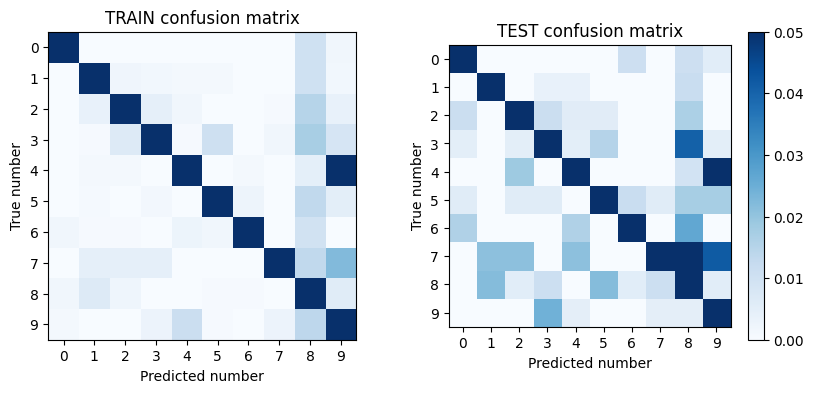

In [ ]:
# Confusion matrices
trainConf = confusion_matrix(train_loader.dataset.tensors[1],train_pred,normalize='true')
testConf  = confusion_matrix(test_loader.dataset.tensors[1], test_pred,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

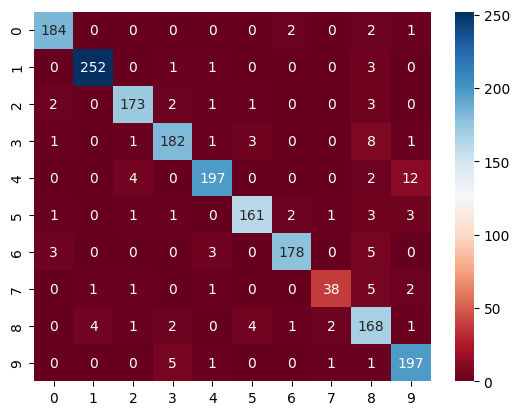

In [ ]:
import seaborn as sns

sns.heatmap(
    confusion_matrix(test_loader.dataset.tensors[1], test_pred,normalize=None),
    annot=True,
    fmt='d',
    cmap='RdBu',
    cbar=True,
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.show()